<a href="https://colab.research.google.com/github/tibaris/EntropicSparsificationNN/blob/main/swiss-roll-sparsify-model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from skimage import io, exposure

import numpy as np
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from scipy.ndimage import gaussian_filter

import time
from skimage.color import rgb2gray
from skimage.transform import rescale

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched

import csv
import pandas as pd
import time
import gc
import sys

In [4]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Case 2: Two turns

In [5]:
train_data = pd.read_csv("/content/swissroll-10000-turn2.csv", header=None)
train_data = train_data.to_numpy()

In [6]:
train_data = np.transpose(train_data)
train_data = torch.from_numpy(train_data)
print(train_data.shape)

train_num = train_data.shape[0]
torch.manual_seed(0)
permutation = torch.randperm(train_num)

train_x = train_data[permutation[:15000],:]
train_y = (permutation[:15000]<train_num/2)*1
train_x = train_x.reshape([train_x.shape[0],train_x.shape[1],1,1])
print(train_x.shape)
print(train_y.shape)

torch.Size([20000, 2])
torch.Size([15000, 2, 1, 1])
torch.Size([15000])


In [7]:
input = train_x[:10000].double()
target = train_y[:10000].double()

input_v = train_x[10000:].double()
target_v = train_y[10000:].double()

test_x = train_data[permutation[15000:],:]
test_x = test_x.reshape([test_x.shape[0],test_x.shape[1],1,1])
test_y = (permutation[15000:]<train_num/2)*1

In [8]:
class SimplePerceptron(nn.Module):

    def __init__(self):
        super(SimplePerceptron, self).__init__()
        self.conv1 = nn.Conv2d(2,400,kernel_size = (1,1))
        self.conv2 = nn.Conv2d(400,400,kernel_size = (1,1))
        self.conv3 = nn.Conv2d(400,400,kernel_size = (1,1))
        self.conv4 = nn.Conv2d(400,1,kernel_size = (1,1))

        self.bn1 = nn.BatchNorm2d(400, affine=False)
        self.bn2 = nn.BatchNorm2d(400, affine=False)
        self.bn3 = nn.BatchNorm2d(400, affine=False)

        self.path_A2 = '/content/estAp3_layer2.csv'
        self.path_b2 = '/content/estB_p3_layer2.csv'
        self.path_W2 = '/content/W_p3_layer2.csv'

        self.path_A3 = '/content/estAp3_layer3.csv'
        self.path_b3 = '/content/estB_p3_layer3.csv'
        self.path_W3 = '/content/W_p3_layer3.csv'

        self.path_A4 = '/content/estAp3_layer4.csv'
        self.path_b4 = '/content/estB_p3_layer4.csv'
        self.path_W4 = '/content/W_p3_layer4.csv'

        self.A2 = pd.read_csv(self.path_A2, header = None)
        self.A2 = self.A2.to_numpy()
        self.A2 = torch.from_numpy(self.A2)
        self.b2 = pd.read_csv(self.path_b2, header = None)
        self.b2 = self.b2.to_numpy()
        self.b2 = torch.squeeze(torch.from_numpy(self.b2))
        self.W2 = pd.read_csv(self.path_W2, header = None).to_numpy()

        self.A3 = pd.read_csv(self.path_A3, header = None)
        self.A3 = self.A3.to_numpy()
        self.A3 = torch.from_numpy(self.A3)
        self.b3 = pd.read_csv(self.path_b3, header = None)
        self.b3 = self.b3.to_numpy()
        self.b3 = torch.squeeze(torch.from_numpy(self.b3))
        #self.b3 = torch.squeeze(torch.from_numpy(self.b3), dim = 1)
        self.W3 = pd.read_csv(self.path_W3, header = None).to_numpy()

        self.A4 = pd.read_csv(self.path_A4, header = None)
        self.A4 = self.A4.to_numpy()
        self.A4 = torch.from_numpy(self.A4)
        self.b4 = pd.read_csv(self.path_b4, header = None)
        self.b4 = self.b4.to_numpy()
        #self.b3 = torch.squeeze(torch.from_numpy(self.b3))
        self.b4 = torch.squeeze(torch.from_numpy(self.b4), dim = 1)
        self.W4 = pd.read_csv(self.path_W4, header = None).to_numpy()
        #print(self.b3.shape)


    def forward(self, x):

        #1st  layer
        #x = self.bn1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.conv4(x)
        #x = F.softmax(x)
        x = F.sigmoid(x)
        return x

    def forward_sparse(self, x):
        #1st  layer
        #x = self.bn1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.my_conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.my_conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.my_conv4(x)
        #x = F.softmax(x)
        x = F.sigmoid(x)
        return x

    def my_conv2(self,x):
        x = torch.matmul(torch.squeeze(self.A2), torch.transpose(torch.squeeze(x),0,1))  #+ torch.squeeze(b)
        #print(x.shape)
        #print(self.b2.shape)
        x = torch.transpose(x,0,1) + self.b2
        x = torch.unsqueeze(torch.unsqueeze(x,2),2)
        #print(x.shape)
        #x = torch.unsqueeze(torch.unsqueeze(res,2),2)
        return x

    def my_conv3(self,x):
        x = torch.matmul(torch.squeeze(self.A3), torch.transpose(torch.squeeze(x),0,1))  #+ torch.squeeze(b)
        #print(x.shape)
        #print(self.b2.shape)
        x = torch.transpose(x,0,1) + self.b3
        x = torch.unsqueeze(torch.unsqueeze(x,2),2)
        #print(x.shape)
        #x = torch.unsqueeze(torch.unsqueeze(res,2),2)
        return x

    def my_conv4(self,x):
        x = torch.matmul(torch.squeeze(self.A4), torch.transpose(torch.squeeze(x),0,1))  #+ torch.squeeze(b)
        #print(x.shape)
        #print(self.b3.shape)
        x = x + self.b4
        #print(x.shape)
        x = torch.unsqueeze(torch.unsqueeze(torch.unsqueeze(x,1),2),2)
        #print(x.shape)
        #x = torch.unsqueeze(torch.unsqueeze(res,2),2)
        return x

    def sparsity(self):
        return (sum(sum(self.W2>0))+sum(sum(self.W3>0))+sum(sum(self.W4>0)))/(sum(sum(self.W2>0))+sum(sum(self.W3>=0))+sum(sum(self.W4>=0)))

    def sparsity2(self):
        return (sum(sum(self.W2>0)), sum(sum(self.W3>0)), sum(sum(self.W4>0)))


In [9]:
model = SimplePerceptron().double()
print(count_parameters(model))

322401


In [10]:
#model.load_state_dict(torch.load("/content/FCC-swiss-roll-2turn-10kbig.pth"))
model.load_state_dict(torch.load("/content/FCC-swiss-roll-2turn-10kbig-corrected.pth"))
model.eval()

SimplePerceptron(
  (conv1): Conv2d(2, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(400, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(400, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(400, 1, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn2): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn3): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [11]:
def accuracy(y1,y2):
    train_acc = torch.sum(y1 == y2)
    #print(train_acc)
    final_train_acc = train_acc/y2.shape[0]
    return final_train_acc

In [12]:
#train
#model.eval()
v = model(input)
v[v>=0.5] = 1
v[v<0.5] = 0
#val
v1 = model(input_v)
v1[v1>=0.5] = 1
v1[v1<0.5] = 0
#test
v2 = model(test_x)
v2[v2>=0.5] = 1
v2[v2<0.5] = 0

print(accuracy(v[:,0,0,0],target))
print(accuracy(v1[:,0,0,0],target_v))
print(accuracy(v2[:,0,0,0],test_y))

tensor(1.)
tensor(1.)
tensor(1.)


In [13]:
#train
v = model.forward_sparse(input)
v[v>=0.5] = 1
v[v<0.5] = 0
#val
v1 = model.forward_sparse(input_v)
v1[v1>=0.5] = 1
v1[v1<0.5] = 0
#test
v2 = model.forward_sparse(test_x)
v2[v2>=0.5] = 1
v2[v2<0.5] = 0

print(accuracy(v[:,0,0,0],target))
print(accuracy(v1[:,0,0,0],target_v))
print(accuracy(v2[:,0,0,0],test_y))

tensor(0.9996)
tensor(0.9996)
tensor(0.9990)


In [14]:
print(model.sparsity())
print(model.sparsity2())

0.1282051282051282
(19, 52, 34)


# Sparse model

In [15]:
class SimplePerceptronSparse(nn.Module):

    def __init__(self):
        super(SimplePerceptronSparse, self).__init__()
        self.conv1 = nn.Conv2d(2,400,kernel_size = (1,1))
        self.conv2 = nn.Conv2d(19,400,kernel_size = (1,1))
        self.conv3 = nn.Conv2d(52,400,kernel_size = (1,1))
        self.conv4 = nn.Conv2d(34,1,kernel_size = (1,1))

        self.bn1 = nn.BatchNorm2d(400, affine=False)
        self.bn2 = nn.BatchNorm2d(400, affine=False)
        self.bn3 = nn.BatchNorm2d(400, affine=False)

        self.path_A2 = '/content/estAp3_layer2.csv'
        self.path_b2 = '/content/estB_p3_layer2.csv'
        self.path_W2 = '/content/W_p3_layer2.csv'

        self.path_A3 = '/content/estAp3_layer3.csv'
        self.path_b3 = '/content/estB_p3_layer3.csv'
        self.path_W3 = '/content/W_p3_layer3.csv'

        self.path_A4 = '/content/estAp3_layer4.csv'
        self.path_b4 = '/content/estB_p3_layer4.csv'
        self.path_W4 = '/content/W_p3_layer4.csv'

        self.A2 = pd.read_csv(self.path_A2, header = None)
        self.A2 = self.A2.to_numpy()
        self.A2 = torch.from_numpy(self.A2)
        self.b2 = pd.read_csv(self.path_b2, header = None)
        self.b2 = self.b2.to_numpy()
        self.b2 = torch.squeeze(torch.from_numpy(self.b2))
        self.W2 = pd.read_csv(self.path_W2, header = None).to_numpy()
        self.W2 = torch.squeeze(torch.from_numpy(self.W2))

        self.A3 = pd.read_csv(self.path_A3, header = None)
        self.A3 = self.A3.to_numpy()
        self.A3 = torch.from_numpy(self.A3)
        self.b3 = pd.read_csv(self.path_b3, header = None)
        self.b3 = self.b3.to_numpy()
        self.b3 = torch.squeeze(torch.from_numpy(self.b3))
        #self.b3 = torch.squeeze(torch.from_numpy(self.b3), dim = 1)
        self.W3 = pd.read_csv(self.path_W3, header = None).to_numpy()
        self.W3 = torch.squeeze(torch.from_numpy(self.W3))

        self.A4 = pd.read_csv(self.path_A4, header = None)
        self.A4 = self.A4.to_numpy()
        self.A4 = torch.from_numpy(self.A4)
        self.b4 = pd.read_csv(self.path_b4, header = None)
        self.b4 = self.b4.to_numpy()
        #self.b3 = torch.squeeze(torch.from_numpy(self.b3))
        self.b4 = torch.squeeze(torch.from_numpy(self.b4), dim = 1)
        self.W4 = pd.read_csv(self.path_W4, header = None).to_numpy()
        self.W4 = torch.squeeze(torch.from_numpy(self.W4))
        #print(self.b3.shape)

        self.A2 = self.A2[:,self.W2>0]
        self.A3 = self.A3[:,self.W3>0]
        self.A4 = self.A4[:,self.W4>0]


    def forward(self, x):

        #1st  layer
        #x = self.bn1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = x[:,self.W2>0]
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = x[:,self.W3>0]
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = x[:,self.W4>0]
        x = self.conv4(x)
        #x = F.softmax(x)
        x = F.sigmoid(x)
        return x

    def init_sparse(self, model):
      self.conv1.weight = model.conv1.weight
      self.conv1.bias = model.conv1.bias
      self.bn1.running_mean = model.bn1.running_mean
      self.bn1.running_var = model.bn1.running_var

      self.conv2.weight = nn.Parameter(self.A2.reshape([self.A2.shape[0],self.A2.shape[1],1,1]));
      self.conv2.bias = nn.Parameter(self.b2)
      self.bn2.running_mean = model.bn2.running_mean
      self.bn2.running_var = model.bn2.running_var

      self.conv3.weight = nn.Parameter(self.A3.reshape([self.A3.shape[0],self.A3.shape[1],1,1]));
      self.conv3.bias = nn.Parameter(self.b3)
      self.bn3.running_mean = model.bn3.running_mean
      self.bn3.running_var = model.bn3.running_var

      #print(self.conv3.weight.shape)
      #print(self.conv3.bias.shape)
      self.conv4.weight = nn.Parameter(self.A4.reshape([self.A4.shape[0],self.A4.shape[1],1,1]));
      self.conv4.bias = nn.Parameter(self.b4)
      #print(self.W1.shape)
      #print(self.W2.shape)

In [16]:
model_sparse = SimplePerceptronSparse().double()
print(count_parameters(model_sparse))
print(count_parameters(model_sparse)/count_parameters(model))
model_sparse.init_sparse(model)
model_sparse.eval()

30435
0.09440107195697284


SimplePerceptronSparse(
  (conv1): Conv2d(2, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(19, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(52, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(34, 1, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn2): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn3): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [17]:
#train
v = model_sparse(input)
v[v>=0.5] = 1
v[v<0.5] = 0
#val
v1 = model_sparse(input_v)
v1[v1>=0.5] = 1
v1[v1<0.5] = 0
#test
v2 = model_sparse(test_x)
v2[v2>=0.5] = 1
v2[v2<0.5] = 0

print(accuracy(v[:,0,0,0],target))
print(accuracy(v1[:,0,0,0],target_v))
print(accuracy(v2[:,0,0,0],test_y))

tensor(0.9996)
tensor(0.9996)
tensor(0.9990)


torch.Size([10001, 2, 1, 1])


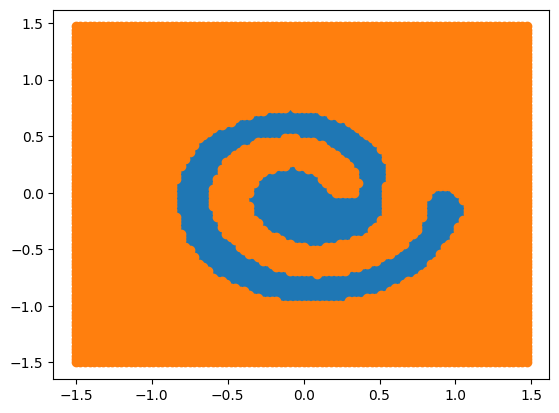

In [18]:
#grid
x1 = np.array([0])
x2 = np.array([0])
for i in range(100):
  for j in range(100):
    x1 = np.concatenate([x1,[-1.5+3/100*i]])
    x2 = np.concatenate([x2,[-1.5+3/100*j]])

grid = torch.zeros([pow(10,4)+1,2,1,1])
print(grid.shape)
grid[:,0,0,0] = torch.from_numpy(x1)
grid[:,1,0,0] = torch.from_numpy(x2)


v = model_sparse(grid.double())
v[v>=0.5] = 1
v[v<0.5] = 0


xA = grid[v[:,0,0,0]==1,0,0,0]
yA = grid[v[:,0,0,0]==1,1,0,0]
xB = grid[v[:,0,0,0]==0,0,0,0]
yB = grid[v[:,0,0,0]==0,1,0,0]
plt.scatter(xA,yA)
plt.scatter(xB,yB)

torch.Size([10001, 2, 1, 1])


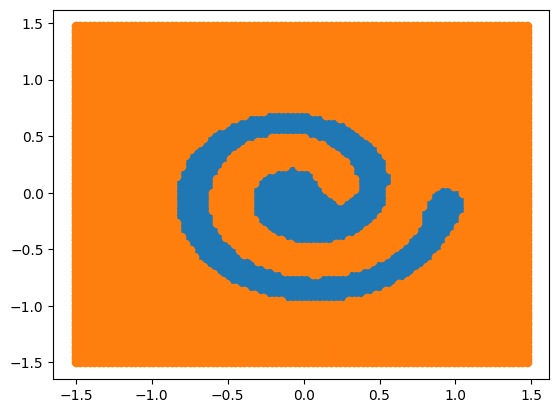

In [19]:
#grid
x1 = np.array([0])
x2 = np.array([0])
for i in range(100):
  for j in range(100):
    x1 = np.concatenate([x1,[-1.5+3/100*i]])
    x2 = np.concatenate([x2,[-1.5+3/100*j]])

grid = torch.zeros([pow(10,4)+1,2,1,1])
print(grid.shape)
grid[:,0,0,0] = torch.from_numpy(x1)
grid[:,1,0,0] = torch.from_numpy(x2)

model.load_state_dict(torch.load("/content/FCC-swiss-roll-2turn-10kbig-corrected.pth"))
model.eval()
v = model(grid.double())
v[v>=0.5] = 1
v[v<0.5] = 0


xA = grid[v[:,0,0,0]==1,0,0,0]
yA = grid[v[:,0,0,0]==1,1,0,0]
xB = grid[v[:,0,0,0]==0,0,0,0]
yB = grid[v[:,0,0,0]==0,1,0,0]
plt.scatter(xA,yA)
plt.scatter(xB,yB)

In [20]:
#model.load_state_dict(torch.load("/content/FCC-swiss-roll-2turn-10kbig.pth"))
model.load_state_dict(torch.load("/content/FCC-swiss-roll-2turn-10kbig-corrected.pth"))
model.eval()

SimplePerceptron(
  (conv1): Conv2d(2, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(400, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(400, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(400, 1, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn2): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn3): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

### Sparse model - efficient implementation

In [21]:
class SimplePerceptronSparse2(nn.Module):

    def __init__(self):
        super(SimplePerceptronSparse2, self).__init__()
        self.conv1 = nn.Conv2d(2,19,kernel_size = (1,1))
        self.conv2 = nn.Conv2d(19,52,kernel_size = (1,1))
        self.conv3 = nn.Conv2d(55,34,kernel_size = (1,1))
        self.conv4 = nn.Conv2d(34,1,kernel_size = (1,1))

        self.bn1 = nn.BatchNorm2d(19, affine=False)
        self.bn2 = nn.BatchNorm2d(52, affine=False)
        self.bn3 = nn.BatchNorm2d(34, affine=False)

        self.path_A2 = '/content/estAp3_layer2.csv'
        self.path_b2 = '/content/estB_p3_layer2.csv'
        self.path_W2 = '/content/W_p3_layer2.csv'

        self.path_A3 = '/content/estAp3_layer3.csv'
        self.path_b3 = '/content/estB_p3_layer3.csv'
        self.path_W3 = '/content/W_p3_layer3.csv'

        self.path_A4 = '/content/estAp3_layer4.csv'
        self.path_b4 = '/content/estB_p3_layer4.csv'
        self.path_W4 = '/content/W_p3_layer4.csv'

        self.A2 = pd.read_csv(self.path_A2, header = None)
        self.A2 = self.A2.to_numpy()
        self.A2 = torch.from_numpy(self.A2)
        self.b2 = pd.read_csv(self.path_b2, header = None)
        self.b2 = self.b2.to_numpy()
        self.b2 = torch.squeeze(torch.from_numpy(self.b2))
        self.W2 = pd.read_csv(self.path_W2, header = None).to_numpy()
        self.W2 = torch.squeeze(torch.from_numpy(self.W2))

        self.A3 = pd.read_csv(self.path_A3, header = None)
        self.A3 = self.A3.to_numpy()
        self.A3 = torch.from_numpy(self.A3)
        self.b3 = pd.read_csv(self.path_b3, header = None)
        self.b3 = self.b3.to_numpy()
        self.b3 = torch.squeeze(torch.from_numpy(self.b3))
        #self.b3 = torch.squeeze(torch.from_numpy(self.b3), dim = 1)
        self.W3 = pd.read_csv(self.path_W3, header = None).to_numpy()
        self.W3 = torch.squeeze(torch.from_numpy(self.W3))

        self.A4 = pd.read_csv(self.path_A4, header = None)
        self.A4 = self.A4.to_numpy()
        self.A4 = torch.from_numpy(self.A4)
        self.b4 = pd.read_csv(self.path_b4, header = None)
        self.b4 = self.b4.to_numpy()
        #self.b3 = torch.squeeze(torch.from_numpy(self.b3))
        self.b4 = torch.squeeze(torch.from_numpy(self.b4), dim = 1)
        self.W4 = pd.read_csv(self.path_W4, header = None).to_numpy()
        self.W4 = torch.squeeze(torch.from_numpy(self.W4))
        #print(self.b3.shape)

        self.A2 = self.A2[:,self.W2>0]
        self.A2 = self.A2[self.W3>0,:]
        self.b2 = self.b2[self.W3>0]

        self.A3 = self.A3[:,self.W3>0]
        self.A3 = self.A3[self.W4>0,:]
        self.b3 = self.b3[self.W4>0]

        self.A4 = self.A4[:,self.W4>0]


    def forward(self, x):

        #1st  layer
        #x = self.bn1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        #x = x[:,self.W2>0]
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        #x = x[:,self.W3>0]
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        #x = x[:,self.W4>0]
        x = self.conv4(x)
        #x = F.softmax(x)
        x = F.sigmoid(x)
        return x

    def init_sparse(self, model):
      self.conv1.weight = nn.Parameter(model.conv1.weight[self.W2>0,:])
      self.conv1.bias = nn.Parameter(model.conv1.bias[self.W2>0])
      self.bn1.running_mean = model.bn1.running_mean[self.W2>0]
      self.bn1.running_var = model.bn1.running_var[self.W2>0]

      self.conv2.weight = nn.Parameter(self.A2.reshape([self.A2.shape[0],self.A2.shape[1],1,1]));
      self.conv2.bias = nn.Parameter(self.b2)
      self.bn2.running_mean = model.bn2.running_mean[self.W3>0]
      self.bn2.running_var = model.bn2.running_var[self.W3>0]

      self.conv3.weight = nn.Parameter(self.A3.reshape([self.A3.shape[0],self.A3.shape[1],1,1]));
      self.conv3.bias = nn.Parameter(self.b3)
      self.bn3.running_mean = model.bn3.running_mean[self.W4>0]
      self.bn3.running_var = model.bn3.running_var[self.W4>0]

      #print(self.conv3.weight.shape)
      #print(self.conv3.bias.shape)
      self.conv4.weight = nn.Parameter(self.A4.reshape([self.A4.shape[0],self.A4.shape[1],1,1]));
      self.conv4.bias = nn.Parameter(self.b4)
      #print(self.W1.shape)
      #print(self.W2.shape)

In [22]:
model_sparse2 = SimplePerceptronSparse2().double()
print(count_parameters(model_sparse2))
print(count_parameters(model_sparse2)/count_parameters(model))
model_sparse2.init_sparse(model)
model_sparse2.eval()

3036
0.009416844240557566


SimplePerceptronSparse2(
  (conv1): Conv2d(2, 19, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(19, 52, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(55, 34, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(34, 1, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(19, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn2): BatchNorm2d(52, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn3): BatchNorm2d(34, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [23]:
#train
v = model_sparse2(input)
v[v>=0.5] = 1
v[v<0.5] = 0
#val
v1 = model_sparse2(input_v)
v1[v1>=0.5] = 1
v1[v1<0.5] = 0
#test
v2 = model_sparse2(test_x)
v2[v2>=0.5] = 1
v2[v2<0.5] = 0

print(accuracy(v[:,0,0,0],target))
print(accuracy(v1[:,0,0,0],target_v))
print(accuracy(v2[:,0,0,0],test_y))

tensor(0.9996)
tensor(0.9996)
tensor(0.9990)


torch.Size([10001, 2, 1, 1])


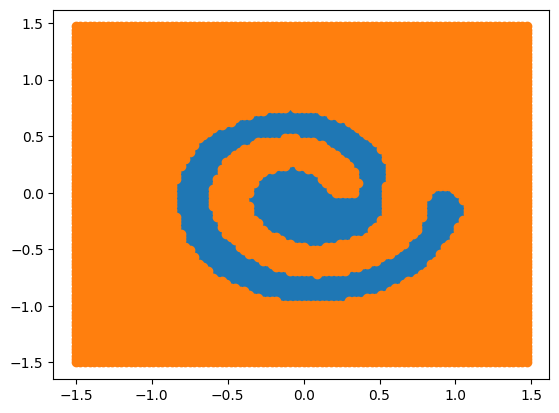

In [24]:
#grid
x1 = np.array([0])
x2 = np.array([0])
for i in range(100):
  for j in range(100):
    x1 = np.concatenate([x1,[-1.5+3/100*i]])
    x2 = np.concatenate([x2,[-1.5+3/100*j]])

grid = torch.zeros([pow(10,4)+1,2,1,1])
print(grid.shape)
grid[:,0,0,0] = torch.from_numpy(x1)
grid[:,1,0,0] = torch.from_numpy(x2)


v = model_sparse2(grid.double())
v[v>=0.5] = 1
v[v<0.5] = 0


xA = grid[v[:,0,0,0]==1,0,0,0]
yA = grid[v[:,0,0,0]==1,1,0,0]
xB = grid[v[:,0,0,0]==0,0,0,0]
yB = grid[v[:,0,0,0]==0,1,0,0]
plt.scatter(xA,yA)
plt.scatter(xB,yB)

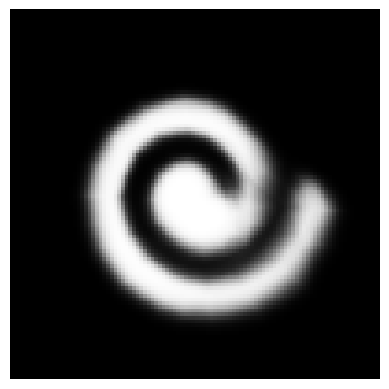

In [25]:
v = model_sparse2(grid.double())
v = v[1:]
v.shape
v1 = torch.reshape(v,[100,100])
v1.shape
plt.axis('off')
plt.imshow(np.rot90(v1.detach().numpy()),cmap="gray")

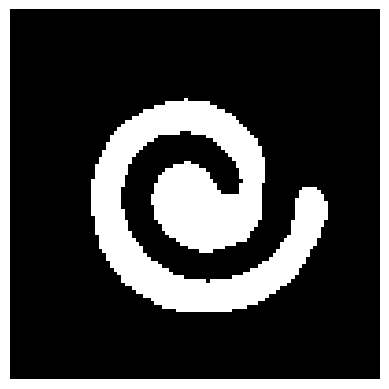

In [26]:
v = model_sparse2(grid.double())
v = v[1:]
v[v>=0.5] = 1
v[v<0.5] = 0
v.shape
v1 = torch.reshape(v,[100,100])
v1.shape
plt.axis('off')
plt.imshow(np.rot90(v1.detach().numpy()),cmap="gray")

Fine tuning

In [27]:
model = model_sparse2
model.train()

SimplePerceptronSparse2(
  (conv1): Conv2d(2, 19, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(19, 52, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(55, 34, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(34, 1, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(19, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn2): BatchNorm2d(52, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn3): BatchNorm2d(34, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [28]:
n_epochs = 10 # or whatever
batch_size = 50 # or whatever
train_num = 10000

optimizer = optim.Adam(model.parameters(), lr = 0.0001)
scheduler = sched.StepLR(optimizer, step_size=4, gamma=0.5)

input = train_x[:10000].double()
target = train_y[:10000].double()

input_v = train_x[10000:].double()
target_v = train_y[10000:].double()

criterion_val = nn.BCELoss()
#criterion_val = loss = nn.CrossEntropyLoss()

for epoch in range(n_epochs):

    # X is a torch Variable
    permutation = torch.randperm(train_num)
    if(epoch % 2 == 1):
        print("Epoch:")
        print(epoch)
        print("Train loss:")
        print(t_loss/train_num*batch_size)
        print("val:")
        val_loss=0
        model.eval()
        v1 = model(input_v)
        #for i in range(200):
            #v1 = model(input_v[(i*50):((i+1)*50)])
            #v2  = target_v[(i*50):((i+1)*50)]
            #v1 = torch.argmax(v1, dim=1)
            #print(v1.shape)
        val_loss = criterion_val(v1[:,0,0,0],target_v)
        #gc.collect()
        #val_loss = val_loss + criterion_val(v1[:,:,0,0],v2)
        #print(criterion_val(model.forward(val_x2), val_y2))
        print("Validation loss:")
        print(val_loss)
        print("--------")
        model.train()
    t_loss = 0
    gc.collect()

    for i in range(0,train_num, batch_size):
        optimizer.zero_grad()
        indices = permutation[i:(i+batch_size)]
        batch_x = input[indices]
        batch_y = target[indices]
        #batch_w = input_w[indices]
        #criterion3 = nn.BCELoss(weight=batch_w)
        #print(batch_x.shape)
        outputs = model.forward(batch_x)
        #print(outputs[:,:,0,0].shape)
        #print(torch.max(outputs[:,:,0,0]))
        #print(torch.max(batch_y))
        #print(torch.min(batch_y))
        #print(batch_y.shape)
        #loss = criterion3(outputs,batch_y)
        loss = criterion_val(outputs[:,0,0,0],batch_y)
        #print(loss)

        if(epoch % 2 == 0):
            t_loss += loss

        loss.backward()
        optimizer.step()
        gc.collect()

    scheduler.step()
    gc.collect()

Epoch:
1
Train loss:
tensor(0.2828, dtype=torch.float64, grad_fn=<MulBackward0>)
val:
Validation loss:
tensor(0.0802, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
--------
Epoch:
3
Train loss:
tensor(0.2464, dtype=torch.float64, grad_fn=<MulBackward0>)
val:
Validation loss:
tensor(0.0629, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
--------
Epoch:
5
Train loss:
tensor(0.2602, dtype=torch.float64, grad_fn=<MulBackward0>)
val:
Validation loss:
tensor(0.0681, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
--------
Epoch:
7
Train loss:
tensor(0.2645, dtype=torch.float64, grad_fn=<MulBackward0>)
val:
Validation loss:
tensor(0.0484, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
--------
Epoch:
9
Train loss:
tensor(0.2540, dtype=torch.float64, grad_fn=<MulBackward0>)
val:
Validation loss:
tensor(0.0526, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
--------


In [29]:
#train
model.eval()
v = model(input)
v[v>=0.5] = 1
v[v<0.5] = 0
#val
v1 = model(input_v)
v1[v1>=0.5] = 1
v1[v1<0.5] = 0
#test
v2 = model(test_x)
v2[v2>=0.5] = 1
v2[v2<0.5] = 0

print(accuracy(v[:,0,0,0],target))
print(accuracy(v1[:,0,0,0],target_v))
print(accuracy(v2[:,0,0,0],test_y))

tensor(1.)
tensor(1.)
tensor(1.)


torch.Size([10001, 2, 1, 1])


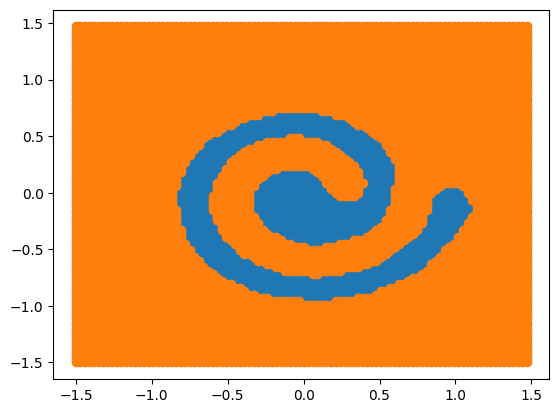

In [ ]:
#grid
x1 = np.array([0])
x2 = np.array([0])
for i in range(100):
  for j in range(100):
    x1 = np.concatenate([x1,[-1.5+3/100*i]])
    x2 = np.concatenate([x2,[-1.5+3/100*j]])

grid = torch.zeros([pow(10,4)+1,2,1,1])
print(grid.shape)
grid[:,0,0,0] = torch.from_numpy(x1)
grid[:,1,0,0] = torch.from_numpy(x2)

v = model(grid.double())
v[v>=0.5] = 1
v[v<0.5] = 0


xA = grid[v[:,0,0,0]==1,0,0,0]
yA = grid[v[:,0,0,0]==1,1,0,0]
xB = grid[v[:,0,0,0]==0,0,0,0]
yB = grid[v[:,0,0,0]==0,1,0,0]
plt.scatter(xA,yA)
plt.scatter(xB,yB)

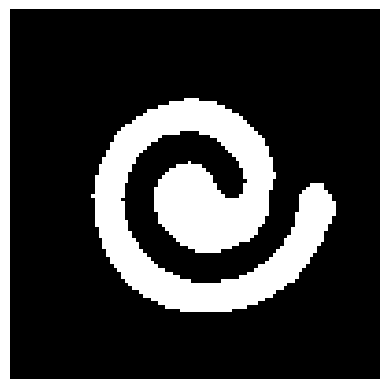

In [30]:
v = model_sparse2(grid.double())
v = v[1:]
v[v>=0.5] = 1
v[v<0.5] = 0
v.shape
v1 = torch.reshape(v,[100,100])
v1.shape
plt.axis('off')
plt.imshow(np.rot90(v1.detach().numpy()),cmap="gray")

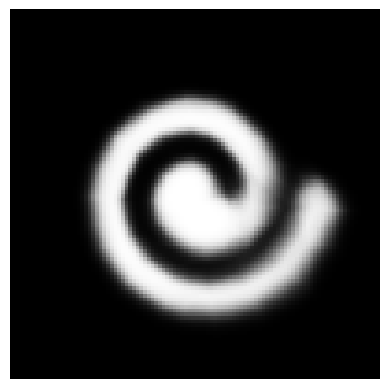

In [31]:
v = model_sparse2(grid.double())
v = v[1:]
v.shape
v1 = torch.reshape(v,[100,100])
v1.shape
plt.axis('off')
plt.imshow(np.rot90(v1.detach().numpy()),cmap="gray")